# Integration with pandas

> Objectives:
> * Use pandas.HDFStore for serializing/deserializing pandas dataframes in HDF5 files
> * Compare in-memory queries (via pandas dataframes) with on-disk ones (via HDFStore)
> * Apply this to visualizing pokemons in Barcelona, New York and more!

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import shutil

matplotlib.rcParams.update({'font.size': 12})

In [3]:
data_dir = "hdfstore"
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)

# pandas.HDFStore()

A pandas DataFrame is a two-dimensional datacontainer. Columns are labeled. DataFrame resemble `numpy.recarray` with a focus on features. DataFrames support slicing, selections, merge's etc.

In [4]:
df = pd.DataFrame(np.random.randn(15, 3), columns=['A', 'B', 'C'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
A    15 non-null float64
B    15 non-null float64
C    15 non-null float64
dtypes: float64(3)
memory usage: 440.0 bytes


In [6]:
df.head()

,A,B,C
0,-1.219892,-0.134655,0.911935
1,0.541194,0.821618,-0.818177
2,-0.042476,-1.056177,0.153303
3,0.621039,0.155785,-0.458812
4,-1.452172,-0.193979,1.143970


In [7]:
fn = os.path.join(data_dir, 'test.h5')
hdfstore = pd.HDFStore(fn, 'w')

`pandas.HDFStore` acts like a `dict` similar to h5py:

In [8]:
hdfstore['my_array'] = df

In [9]:
print(hdfstore)

<class 'pandas.io.pytables.HDFStore'>
File path: hdfstore\test.h5
/my_array            frame        (shape->[15,3])


By using `HDFStore.put()` we can specify options such as the dataset type, indexing etc.

In [10]:
hdfstore.put('my_table', df[:5], format='table')
hdfstore

<class 'pandas.io.pytables.HDFStore'>
File path: hdfstore\test.h5
/my_array            frame        (shape->[15,3])                                      
/my_table            frame_table  (typ->appendable,nrows->5,ncols->3,indexers->[index])

In [11]:
hdfstore.append('my_table', df[5:])
hdfstore

<class 'pandas.io.pytables.HDFStore'>
File path: hdfstore\test.h5
/my_array            frame        (shape->[15,3])                                       
/my_table            frame_table  (typ->appendable,nrows->15,ncols->3,indexers->[index])

In [12]:
hdfstore.close()

In [13]:
!ptdump -v {fn}

/ (RootGroup) ''
/my_array (Group) ''
/my_array/axis0 (Array(3,)) ''
  atom := StringAtom(itemsize=1, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/my_array/axis1 (Array(15,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/my_array/block0_items (Array(3,)) ''
  atom := StringAtom(itemsize=1, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/my_array/block0_values (Array(15, 3)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/my_table (Group) ''
/my_table/table (Table(15,)) ''
  description := {
  "index": Int64Col(shape=(), dflt=0, pos=0),
  "values_block_0": Float64Col(shape=(3,), dflt=0.0, pos=1)}
  byteorder := 'little'
  chunkshape := (2048,)
  autoindex := True
  colindexes := {
    "index": Index(6, medium, shuffle, z

Note that only the index column is indexed.

use `data_columns=[]` to index other columns. Use `data_columns=True` to index all columns.

### to_hdf()
A `pandas.DataFrame` has a `to_hdf()` method, which is similar to:

```
with pd.HDFStore(filename, mode='w') as hdfstore:
   hdfstore.put(...)
```

`to_hdf()` only supports BLOSC additional compressors (`complib='blosc:lz4'`) from pandas v0.20.2 (released June 2017)

In [33]:
tmpfn = os.path.join(data_dir, 'tmp.h5')
df.to_hdf(tmpfn, 'my_table', format='table', mode='w')

In [35]:
!ptdump {tmpfn}

/ (RootGroup) ''
/my_table (Group) ''
/my_table/table (Table(15,)) ''


### Exercise

Open the hdf5 file with `h5py` or `pytables` and investigate the contents. (Alternative use `h5ls`, `h5dump` and/or `ptdump`)

In [36]:
#
#
# Solution starts here
#
#

In [37]:
import h5py

In [38]:
f = h5py.File(fn)

In [39]:
list(f)

['my_array', 'my_table']

In [41]:
f['my_array/axis0'][:]

array([b'A', b'B', b'C'],
      dtype='|S1')

In [43]:
f['/my_array/block0_values'][:]

array([[-1.21989212, -0.13465493,  0.91193458],
       [ 0.54119449,  0.82161777, -0.81817688],
       [-0.04247554, -1.05617662,  0.15330261],
       [ 0.62103911,  0.15578534, -0.45881189],
       [-1.45217224, -0.1939791 ,  1.14396982],
       [-1.10735388, -0.78005967, -1.09202626],
       [-0.74387834,  0.50591986, -0.53376584],
       [-1.51939584, -0.5736766 , -0.09859051],
       [ 0.66055113,  1.95873777, -0.12694566],
       [ 1.2395845 ,  0.28062004,  1.10683953],
       [ 0.92301778,  0.15212201,  1.79764362],
       [ 1.35396729,  0.3282071 ,  1.14314874],
       [-0.96101902, -0.61263415,  0.03308953],
       [-0.86477161, -0.31579374, -0.98625643],
       [-0.20607096,  1.21261057,  1.77250409]])

In [44]:
f.close()

## Large CSV dataset: Pokemon sightings

Let's see how HDF5 integrates with pandas while we are having fun visualizing the different kinds of pokemons in different geographical areas.  The dataset that we will be using here can obtained from https://www.kaggle.com/semioniy/predictemall.

The zipped version of the dataset (`300k_csv.zip` is about 38Mbytes. The original CSV is about 480Mb).

In [45]:
%%time
df = pd.read_csv('datasets/pokemon/300k_csv.zip')

Wall time: 18.3 s


<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


In [46]:
df[['city','latitude', 'longitude']].head(15)

,city,latitude,longitude
0,Mexico_City,20.525745,-97.460829
1,Mexico_City,20.523695,-97.461167
2,New_York,38.903590,-77.199780
3,Los_Angeles,47.665903,-122.312561
4,Los_Angeles,47.666454,-122.311628
5,Perth,-31.954980,115.853609
6,Perth,-31.954245,115.852038
7,Chicago,26.235257,-98.197591
8,Mexico_City,20.525554,-97.458800
9,New_York,32.928558,-84.340278


In [47]:
# Clean up some things:
# Replace ? by a float representation
df['pokestopDistanceKm'].replace({'?': -999.9}, inplace=True)
df['pokestopDistanceKm'] = df.pokestopDistanceKm.astype(float)
# Rename column with reserved name class by target
df.rename(columns={'class': 'target'}, inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296021 entries, 0 to 296020
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 137.8+ MB


In [49]:
df.head()

,pokemonId,latitude,longitude,appearedLocalTime,_id,cellId_90m,cellId_180m,cellId_370m,cellId_730m,cellId_1460m,...,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151,target
0,16,20.525745,-97.460829,2016-09-08T03:57:45,NTgxMDkzOTk4MTM5MjUwMjIzNw==,9645139108510564000,9645139108711890000,9645139108443455000,9645139109517197000,9645139113812165000,...,False,False,False,False,False,False,False,False,False,16
1,133,20.523695,-97.461167,2016-09-08T03:57:37,OTQ1NDgzODc1MjM3NDEzMTI2MQ==,9645139109852742000,9645139109785633000,9645139110590940000,9645139109517197000,9645139113812165000,...,False,False,False,False,False,False,False,False,False,133
2,16,38.903590,-77.199780,2016-09-08T03:57:25,NTQ0OTQ0NDA1Nzg2ODg3OTg2OQ==,9923201472785285000,9923201472986612000,9923201473791918000,9923201477013144000,9923201481308110000,...,False,False,False,False,False,False,False,False,False,16
3,13,47.665903,-122.312561,2016-09-08T03:56:22,NTU2MTU1NDM4NzA2MDk1MDcxNw==,6093392705025474600,6093392705092583400,6093392705897889800,6093392702676664300,6093392715561566200,...,False,False,False,False,False,False,False,False,False,13
4,133,47.666454,-122.311628,2016-09-08T03:56:08,MTY2ODg4MTAzMTczMDE0MTUwNTM=,6093392707709829100,6093392707776938000,6093392708045373400,6093392711266598900,6093392715561566200,...,False,False,False,False,False,False,False,False,False,133


## Storing in HDF5 compressed form with pandas.HDFStore

Let's store the dataframe in HDF5 and indexing just the columns that we are interested for doing our queries (remember that the indexes take space on-disk, and we want to avoid cluttering the files unnecessarily). 

In [50]:
%%time
complib, codec = 'blosc', 'zstd'
complevel = 6
filename = "%s/pokemons-%s-%s-%d.h5" % (data_dir, complib, codec, complevel)
with pd.HDFStore(filename, mode='w') as hdf:
# We only index the columns needed
    hdf.put(key='pokemons', value=df, data_columns=['target', 'latitude', 'longitude'],
            format='table', complevel=complevel, complib="%s:%s" % (complib, codec))

Wall time: 14.6 s


In [51]:
!ls -lh {data_dir}

total 35M
-rw-r--r-- 1 tomkooij 197613 83K Jun 22 13:26 foobar.h5
-rw-r--r-- 1 tomkooij 197613 35M Jun 22 13:28 pokemons-blosc-zstd-6.h5
-rw-r--r-- 1 tomkooij 197613 88K Jun 22 13:23 test.h5
-rw-r--r-- 1 tomkooij 197613 83K Jun 22 13:26 tmp.h5


In [52]:
!ptdump {filename}

/ (RootGroup) ''
/pokemons (Group) ''
/pokemons/table (Table(296021,), shuffle, blosc:zstd(6)) ''


So, the `pandas.HDFStore` can store the dataframe using a space that is close (even slightly smaller!) to the original zipped CSV file.  In addition, the created HDF5 file also contains indexes (specifically for columns 'target', 'latitude' and 'longitude') for faster on-disk querying.

## Select comparison: in-memory vs on-disk

In [53]:
# Set the query for Central Park, NY coordinates
central_park_coords = "(latitude > 40.764) & (latitude < 40.786) & (longitude > -73.982) & (longitude < -73.96)"

In [54]:
%%time
df2 = df.query(central_park_coords)  # in-memory query

Wall time: 25 ms


In [55]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=central_park_coords)   # run only once. Hot/cold query.

Wall time: 229 ms


So we can do queries on-disk (i.e. not limited by the amount of memory) that are under 1 second, which is quite convenient for interactive exploration.

In [56]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 9067 to 289092
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 334.7+ KB


## Exercise 1

Compare the cost of loading the whole CSV from pandas with respect to loading the data from the HDF5 file.

**Optional**: Store the csv in an HDF5 file using complib **blosc:lz4** and complevel **9**. Compare the results in terms of space on-disk and query times.

In [57]:
#
#
# SOLUTION STARTS HERE
#
#

In [58]:
%%time
df = pd.read_csv('datasets/pokemon/300k_csv.zip')

Wall time: 19.1 s


<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


In [59]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df = hdf.get(key='pokemons')

Wall time: 4.63 s


In [60]:
%%time
complib, codec = 'blosc', 'lz4'
complevel = 6
lz4_file = "%s/pokemons-%s-%s-%d.h5" % (data_dir, complib, codec, complevel)
with pd.HDFStore(lz4_file, mode='w') as hdf:
    # We only index the columns needed
    hdf.put(key='pokemons', value=df, data_columns=['target', 'latitude', 'longitude'], format='table',
            complevel=complevel, complib="%s:%s" % (complib, codec))

Wall time: 6.81 s


In [61]:
%%time
with pd.HDFStore(lz4_file, mode='r') as hdf:
    df = hdf.get(key='pokemons')

Wall time: 4.93 s


In [62]:
%%time
with pd.HDFStore(lz4_file, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=central_park_coords)

Wall time: 243 ms


In [63]:
%%time
# Query the original file (compressed with Zstd)
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=central_park_coords)

Wall time: 226 ms


In [64]:
!ls -lh {data_dir}

total 92M
-rw-r--r-- 1 tomkooij 197613 83K Jun 22 13:26 foobar.h5
-rw-r--r-- 1 tomkooij 197613 58M Jun 22 13:29 pokemons-blosc-lz4-6.h5
-rw-r--r-- 1 tomkooij 197613 35M Jun 22 13:28 pokemons-blosc-zstd-6.h5
-rw-r--r-- 1 tomkooij 197613 88K Jun 22 13:23 test.h5
-rw-r--r-- 1 tomkooij 197613 83K Jun 22 13:26 tmp.h5


So using "blosc:lz4" compresses less than "blosc:zstd", but in exchange it leads to better query times.

## Plotting Central Park Pokemons

Let's use [cartopy](http://scitools.org.uk/cartopy/) for plotting pokemon in a map of Central Park, NY.

In [65]:
def plot_pokemons(df, extent, detail_level):
        
    tiler = cimgt.OSM()
    fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=tiler.crs))
    # Grid and limits
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    ax.set_extent(extent)
    # Tiler image and detail level
    ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(len(df)):
        image = plt.imread('datasets/pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

In [66]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=central_park_coords)

Wall time: 229 ms


In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 9067 to 289092
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 334.7+ KB


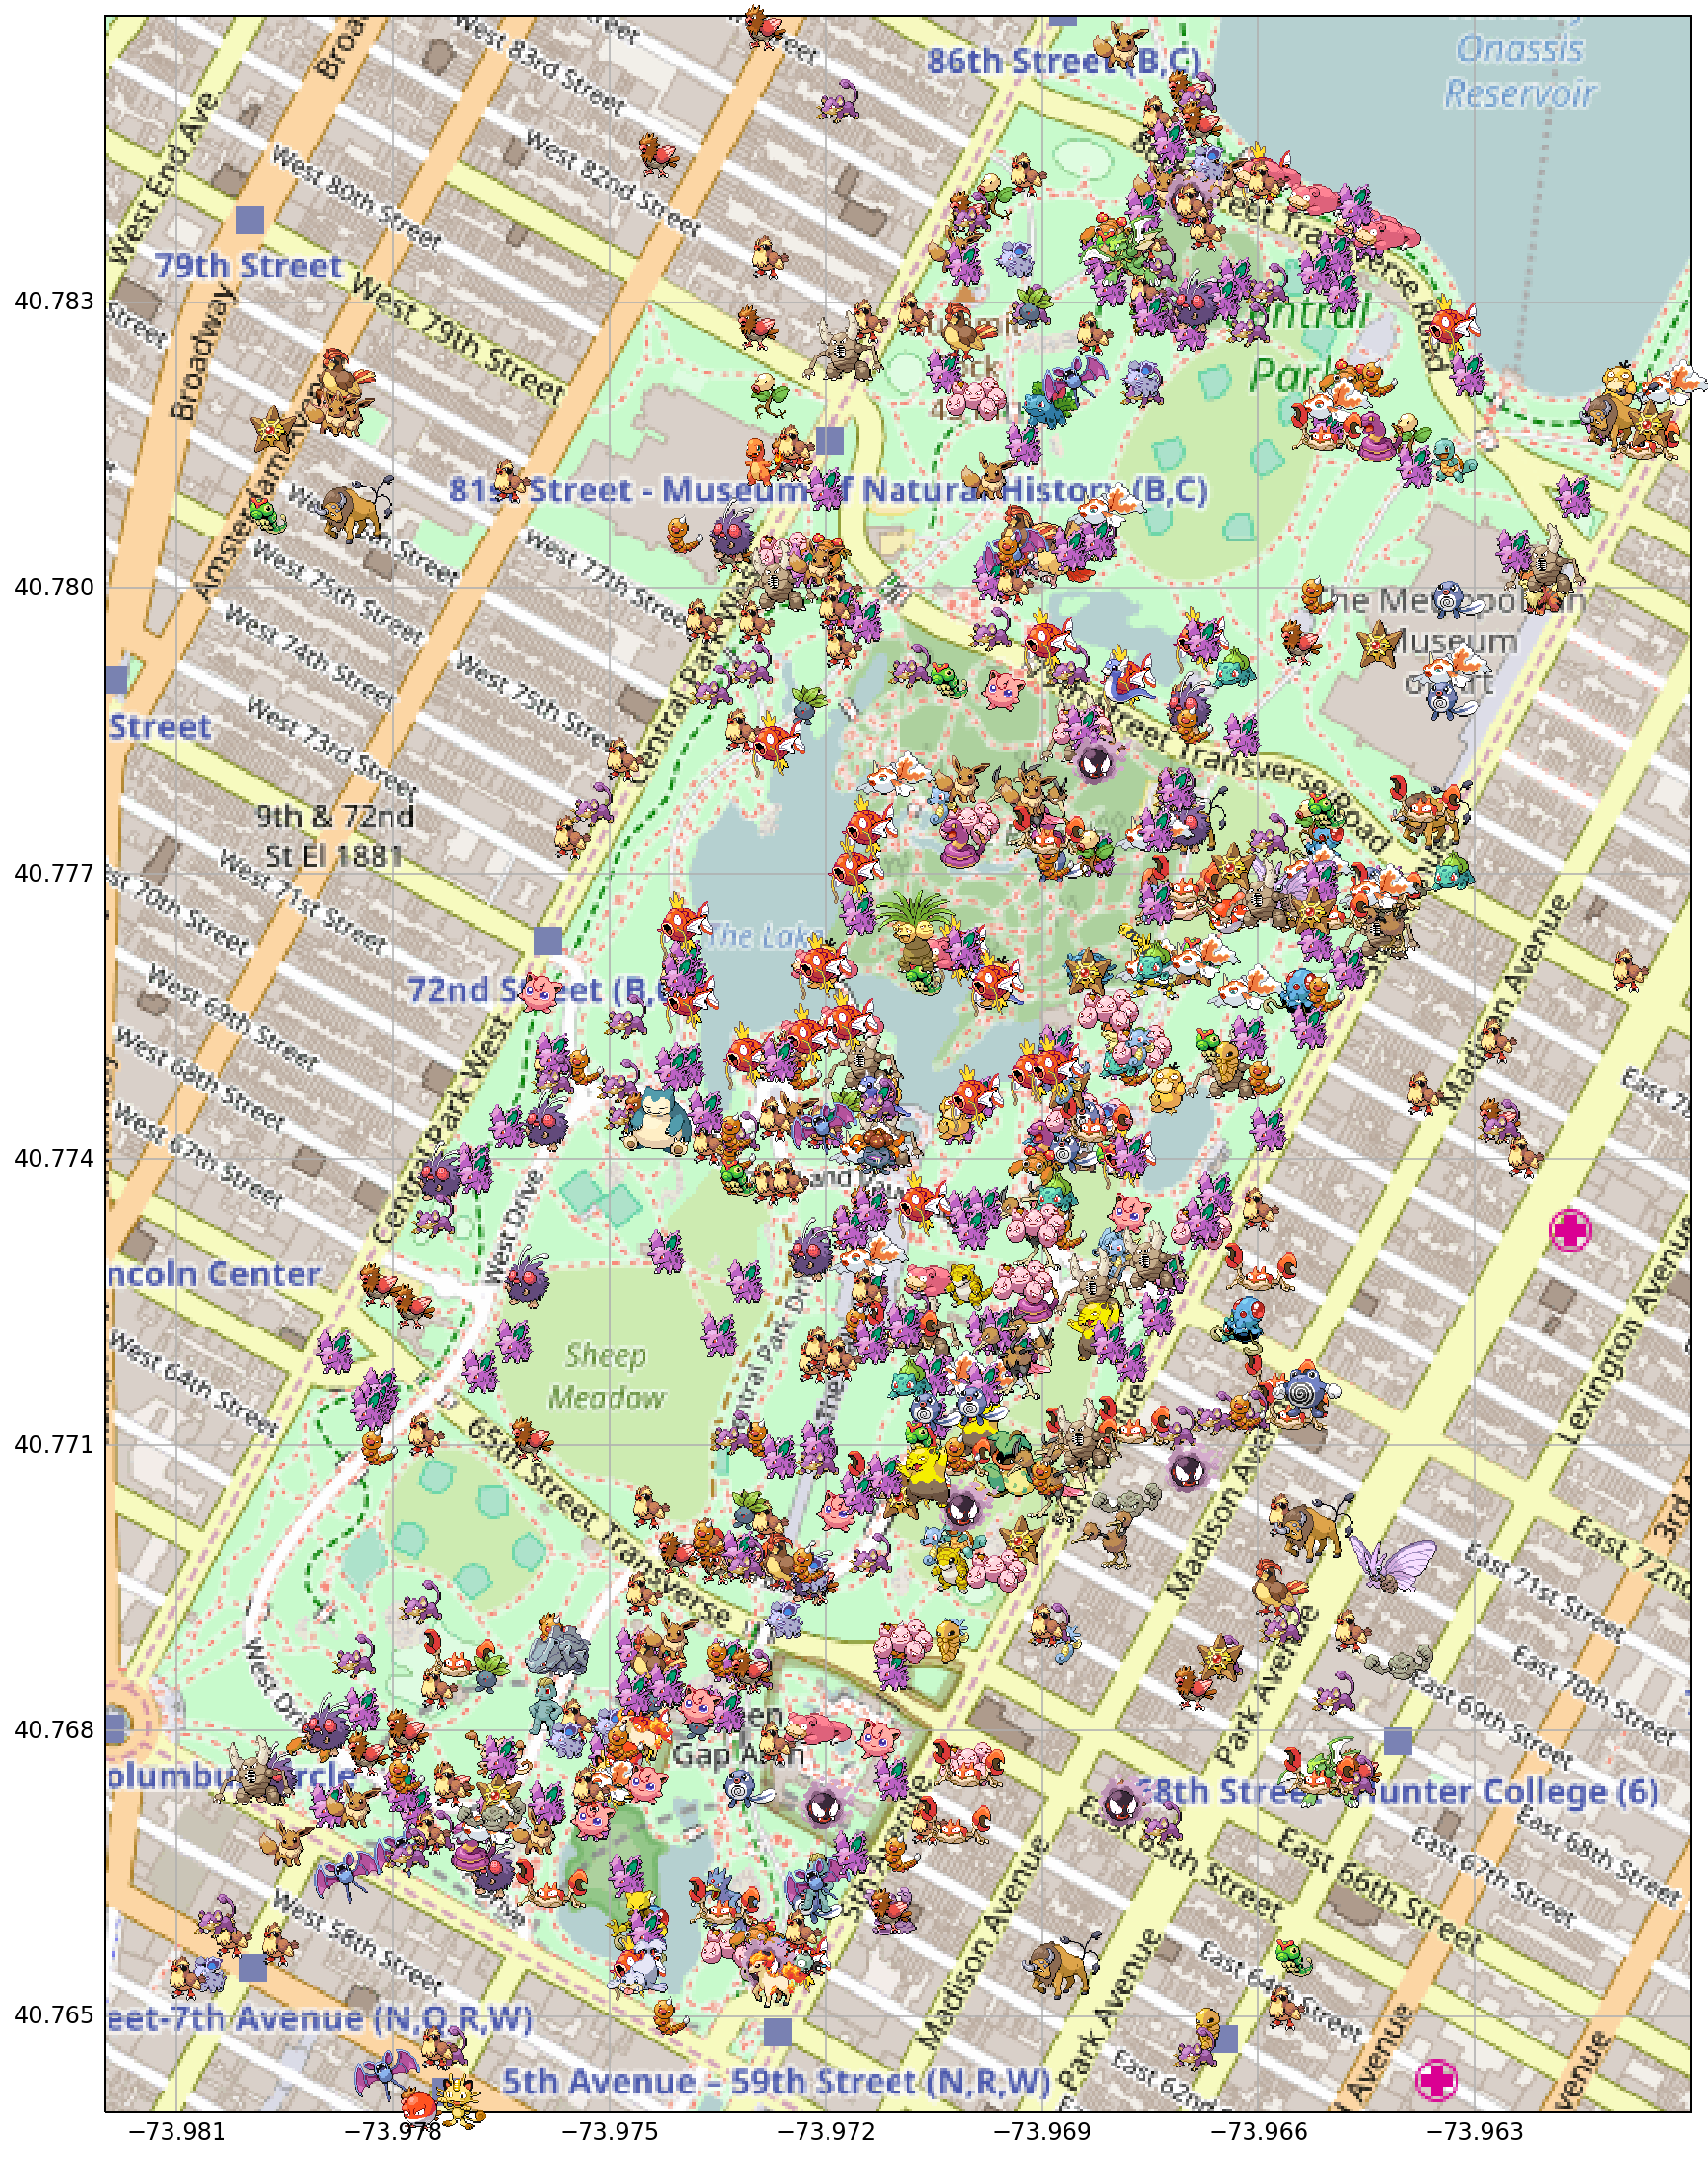

In [68]:
extent = (-73.982, -73.96, 40.764, 40.786)
detail_level = 15
plot_pokemons(df2, extent, detail_level)

### Exercise 2

Plot pokemons in around the Austin AT&T Convention center and the Texas Capitol.

Tip: http://www.bufa.es/google-maps-latitud-longitud/

In [69]:
central_park_coords = "(latitude > 30.) & (latitude < 31.) & (longitude < -97) & (longitude > -98)"

In [90]:
#
# TEMP FIDDLE  52.374, 4.75   52.351 4.98
  #
central_park_coords = "(latitude > 52.351) & (latitude < 52.374) & (longitude < 4.98) & (longitude > 4.75)" #adam
central_park_coords = "(latitude > 51.501) & (latitude < 51.516) & (longitude < -0.07) & (longitude > -0.1)" #london

In [91]:
with pd.HDFStore(filename, mode='r') as hdf:    
    df2 = hdf.select(key='pokemons', where=central_park_coords)

In [92]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 8990 to 270934
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 87.7+ KB


In [86]:
df2.head(53)

,pokemonId,latitude,longitude,appearedLocalTime,_id,cellId_90m,cellId_180m,cellId_370m,cellId_730m,cellId_1460m,...,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151,target
82509,118,52.358243,4.898386,2016-09-06T08:44:28,NTQ4MjQ5MjI4NjI4NTgyMjMxNw==,5171831745623883800,5171831745556774900,5171831745825210400,5171831749046435800,5171831753341403100,...,False,False,False,False,False,False,False,False,False,118
82545,129,52.360029,4.899533,2016-09-06T08:44:00,OTE1MzMwNzIzNjg1Mzc2NTQyMQ==,5171831752871641100,5171831753072967700,5171831752267661300,5171831749046435800,5171831753341403100,...,False,False,False,False,False,False,False,False,False,129
82645,118,52.360096,4.895913,2016-09-06T08:42:33,NjU4MzgwNDAxOTM4Mjc1NjUwOQ==,5171831750992592900,5171831750925484000,5171831750120177700,5171831749046435800,5171831753341403100,...,False,False,False,False,False,False,False,False,False,118
82650,129,52.361827,4.898399,2016-09-06T08:42:23,MTU3NTQ5NTk3MDEyOTY0NTI2Mzc=,5171831755287560200,5171831755220451300,5171831754415145000,5171831757636370400,5171831753341403100,...,False,False,False,False,False,False,False,False,False,129
82668,54,52.360110,4.891558,2016-09-06T08:42:03,MTYyOTExNDc1Mjg4MTc5MTY1,5171832135257948200,5171832135325057000,5171832134519750700,5171832135593492500,5171832131298525200,...,False,False,False,False,False,False,False,False,False,54
82680,120,52.357953,4.895326,2016-09-06T08:41:51,NDE5MzE4MDY5NDQzMjY2ODI1Mw==,5171831748710891500,5171831748778000400,5171831747972694000,5171831749046435800,5171831753341403100,...,False,False,False,False,False,False,False,False,False,120
82684,13,52.362480,4.892704,2016-09-06T08:41:50,MTQxMjY0NzYyNjAwODkxNTU2NjE=,5171832128144408600,5171832128345735200,5171832128077299700,5171832127003557900,5171832131298525200,...,False,False,False,False,False,False,False,False,False,13
82689,129,52.363716,4.897073,2016-09-06T08:41:41,MTA1MjkyOTYwODM5ODI1NTQ3NDk=,5171831757569261600,5171831757367935000,5171831756562628600,5171831757636370400,5171831753341403100,...,False,False,False,False,False,False,False,False,False,129
82774,118,52.360406,4.896487,2016-09-06T08:40:22,MTQwNjQ3NDAyNjE2NzAzNTExNjU=,5171831750992592900,5171831750925484000,5171831750120177700,5171831749046435800,5171831753341403100,...,False,False,False,False,False,False,False,False,False,118
82780,120,52.364280,4.899560,2016-09-06T08:40:16,MTgzNjIwNzc1NTUzOTM5NDExODE=,5171831761058922500,5171831761126031400,5171831760857595900,5171831757636370400,5171831753341403100,...,False,False,False,False,False,False,False,False,False,120


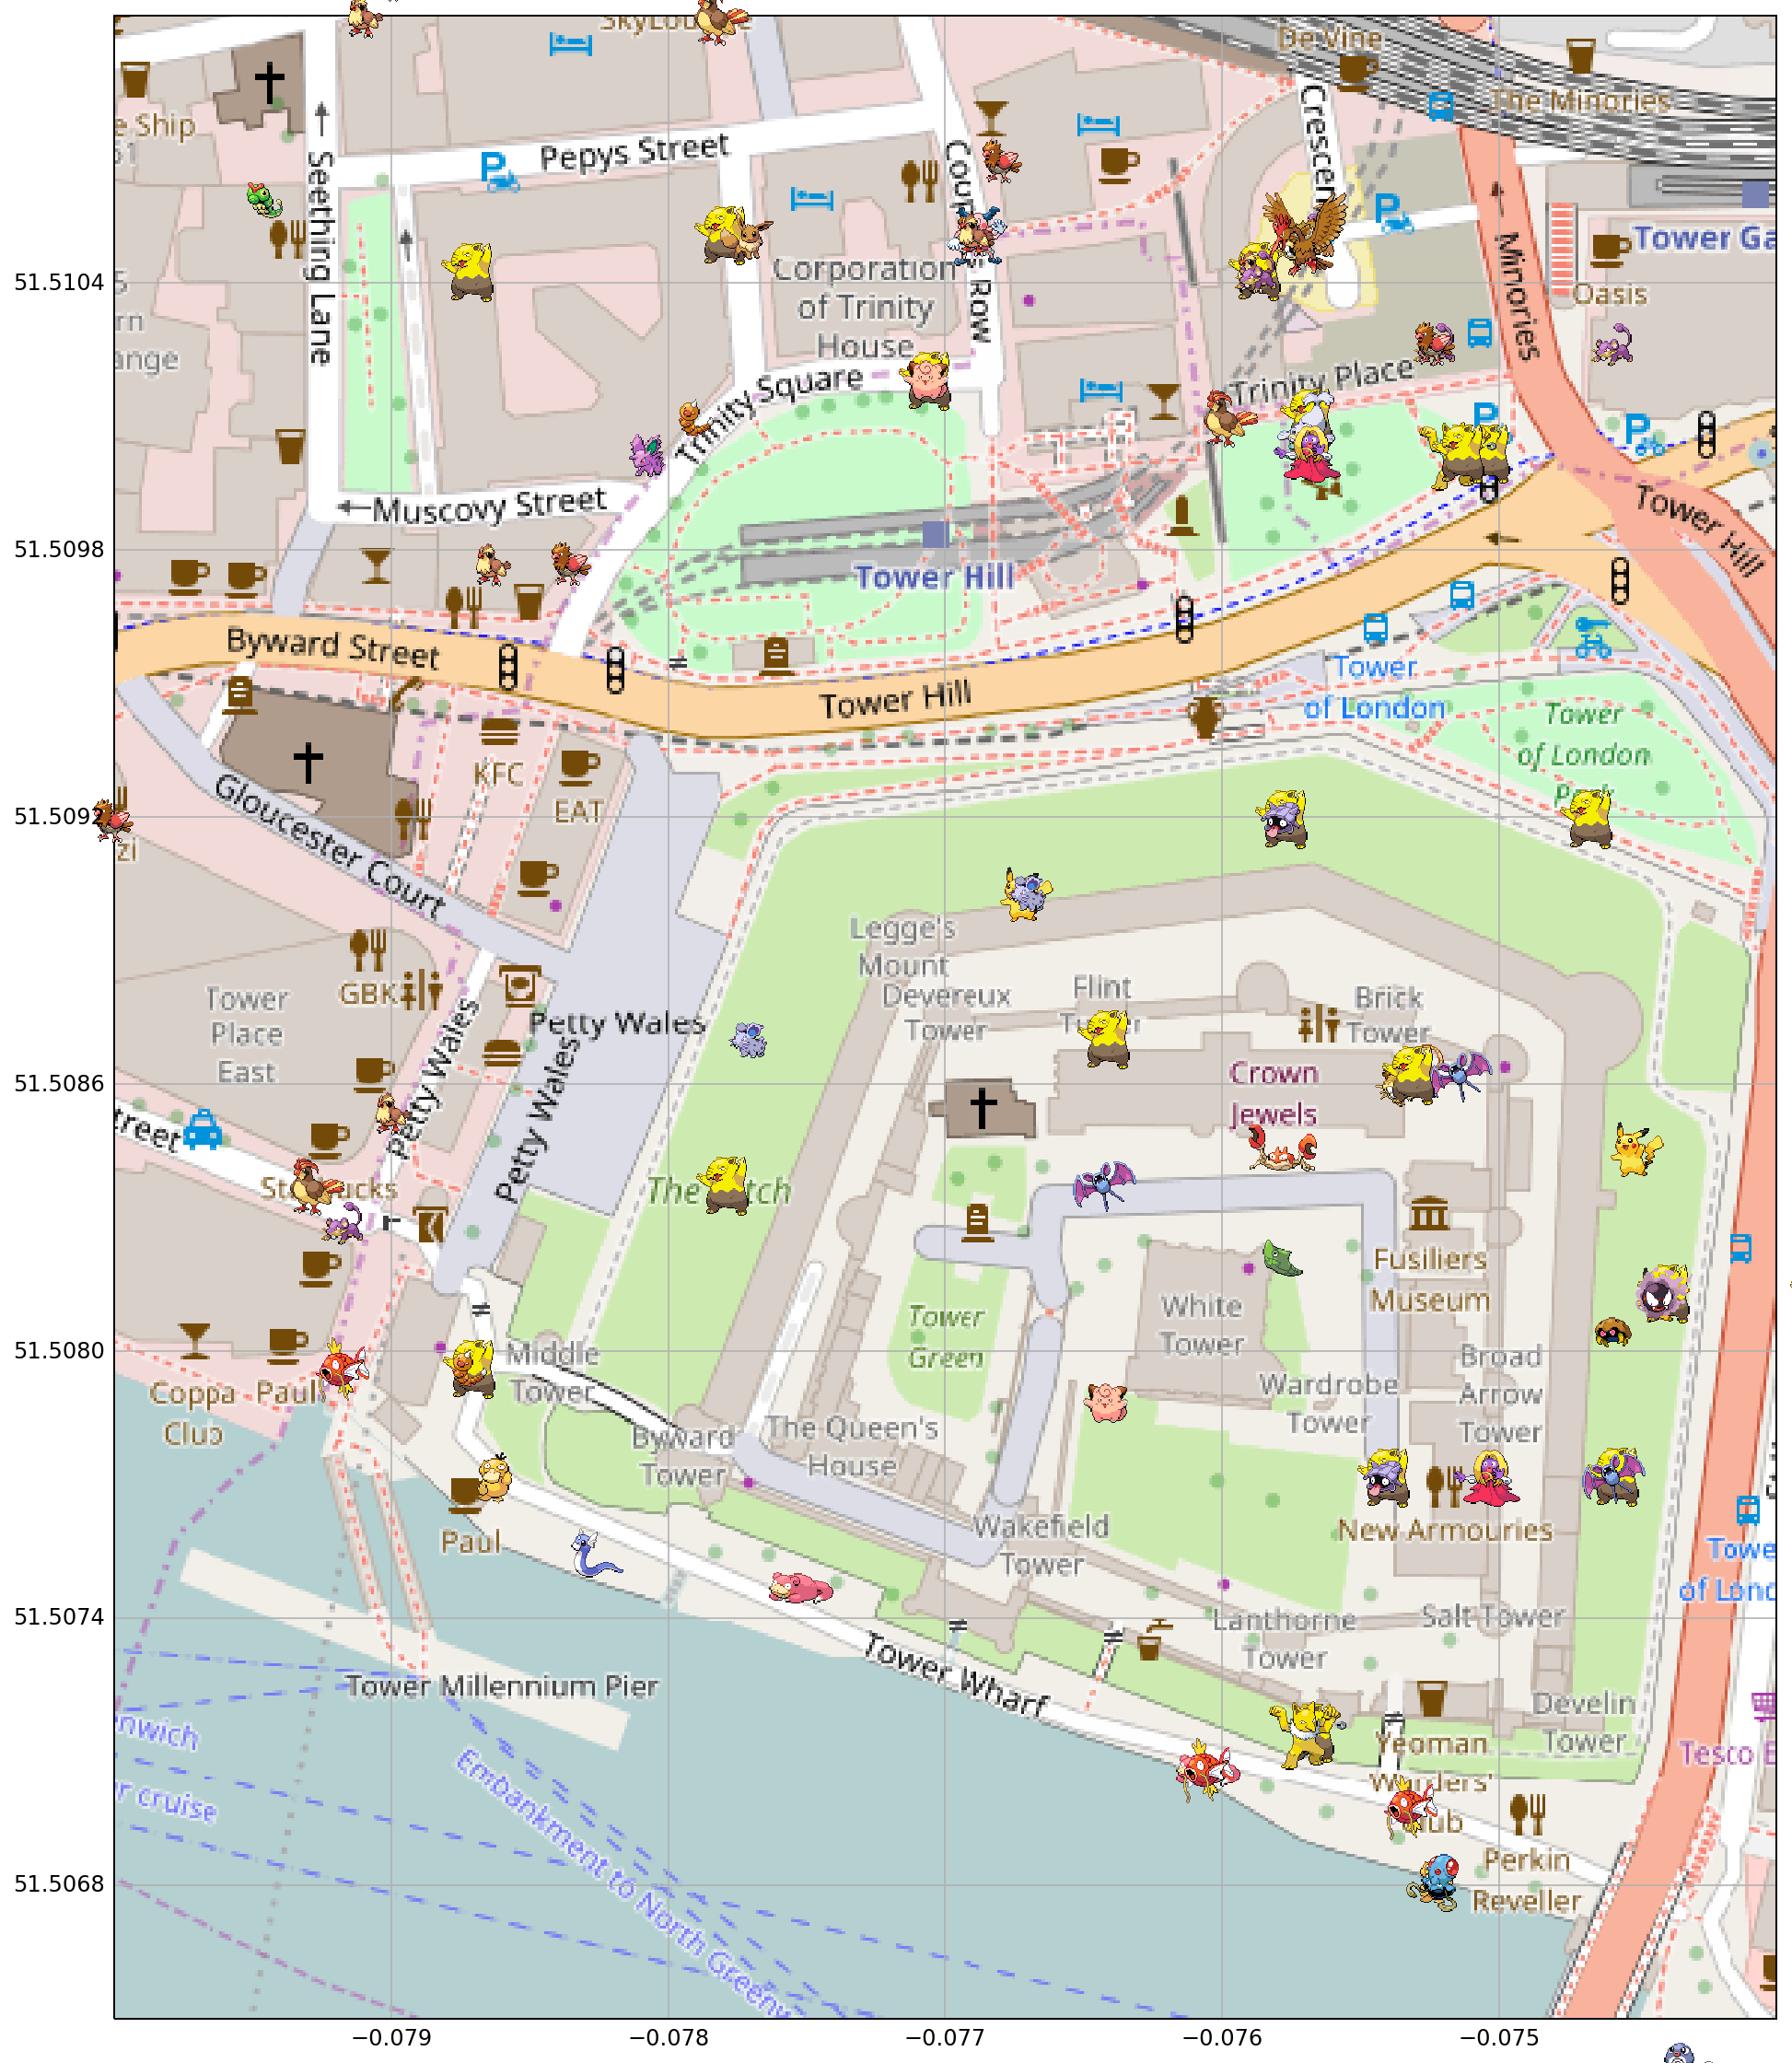

In [105]:
extent = (-0.080, -0.074, 51.5065, 51.511)
#extent = (-0.086, -0.07, 51.506, 51.513) # tower of london (large)

#extent = (4.88, 4.91, 52.355, 52.375)   # adam 

detail_level = 17
plot_pokemons(df2, extent, detail_level)

### Exercise 3

There are some pokemon which are exclusive of certain regions; these are Farfetch'd (**target**=83), Kangashkan (**target**=115), Mr. Mime (**target**=122) and Tauros (**target**=128).  Plot the world map with only these pokemon.  

**Tip**: for plotting a world-wide view, copy the `plot_pokemons` function and replace the following lines: 

```python
tiler = cimgt.OSM()
fig, ax = plt.subplots(figsize=(25, 20), 
                       subplot_kw=dict(projection=tiler.crs))
# Grid and limits
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
ax.set_extent(extent)
# Tiler image and detail level
ax.add_image(tiler, detail_level) # always use low detail level during exploration
```

by

```python
fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
ax.stock_img()
```


In [102]:
#
#
# Solution starts here
#
#

In [ ]:
with pd.HDFStore(filename, mode='r') as hdf: 
    df2 = hdf.select(key='pokemons', where='target=[122,128,115,83]')

In [ ]:
def plot_pokemons(df, extent=None, detail_level=1, world_mode=False):
    
    if world_mode:
        fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
        ax.stock_img()
    else:
        tiler = cimgt.OSM()
        fig, ax = plt.subplots(figsize=(25, 20), 
                               subplot_kw=dict(projection=tiler.crs))
        # Grid and limits
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        ax.set_extent(extent)
        # Tiler image and detail level
        ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(len(df)):
        image = plt.imread('pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

In [ ]:
plot_pokemons(df2, world_mode=True)